# { link to our video }

# Predict Customer Churn

This project addresses the critical issue of customer churn in the telecommunications industry, which can significantly impact revenue and growth. By leveraging historical customer data, our objective is to develop robust machine learning models that can predict customer churn effectively. These models aim to identify potential churners early, enabling proactive measures to enhance customer retention strategies.


## EDA & Cleaning

Import requried libraries:

In [29]:
import pandas as pd
import numpy as np

Load the training data from the working directory

In [30]:
data = pd.read_csv('/kaggle/input/data-idc6210-final-project/train.csv')
data.head()

,id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,label
0,1815,Male,0,Yes,Yes,12,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.70,258.35,0
1,5947,Female,0,No,No,42,Yes,No,DSL,Yes,...,Yes,Yes,No,Yes,One year,No,Credit card (automatic),73.90,3160.55,1
2,3882,Male,0,Yes,No,71,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,No,Bank transfer (automatic),65.15,4681.75,0
3,2390,Male,0,Yes,Yes,71,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,No,Electronic check,85.45,6300.85,0
4,3677,Male,0,No,No,30,Yes,No,DSL,Yes,...,No,Yes,Yes,No,One year,No,Electronic check,70.40,2044.75,0


Column Definitions:
- id: Unique identifier for each customer data instance.
- gender: Categorical variable representing the gender of the customer.
- senior_citizen: Binary variable indicating if the customer is a senior citizen (1) or not (0).
- partner: Categorical variable indicating if the customer has a partner or not.
- dependents: Categorical variable indicating if the customer has dependents or not.
- tenure: Continuous variable representing the number of months the customer has been with the company.
- phone_service: Categorical variable indicating if the customer has phone service or not.
- multiple_lines: Categorical variable indicating the type of phone service the customer has (e.g., single line, multiple lines).
- internet_service: Categorical variable indicating the type of internet service the customer has (e.g., DSL, fiber optic).
- online_security: Categorical variable indicating if the customer has online security or not.
- online_backup: Categorical variable indicating if the customer has online backup or not.
- device_protection: Categorical variable indicating if the customer has device protection or not.
- tech_support: Categorical variable indicating if the customer has tech support or not.
- streaming_tv: Categorical variable indicating if the customer has streaming TV or not.
- streaming_movies: Categorical variable indicating if the customer has streaming movies or not.
- contract: Categorical variable representing the type of contract the customer has (e.g., month-to-month, one year, two year).
- paperless_billing: Categorical variable indicating if the customer has opted for paperless billing or not.
- payment_method: Categorical variable representing the payment method used by the customer.
- monthly_charges: Continuous variable representing the monthly charges for the customer.
- total_charges: Continuous variable representing the total charges for the customer.
- label: Target variable column indicating if the customer churned (1) or not (0).

Drop any rows that are null. The `how=all` parameter ensure that rows are only dropped if they are entirely null.

In [31]:
data = data.dropna(how='all')

For data exploration, we will save the dataset as a new variable that we can reference later. Any transformations that we find will be helpful, they will be integrated into the pipeline.

In [32]:
data_train = data

Inspect column data types and check for nulls:

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5634 entries, 0 to 5633
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5634 non-null   int64  
 1   gender             5634 non-null   object 
 2   senior_citizen     5634 non-null   int64  
 3   partner            5634 non-null   object 
 4   dependents         5634 non-null   object 
 5   tenure             5634 non-null   int64  
 6   phone_service      5634 non-null   object 
 7   multiple_lines     5634 non-null   object 
 8   internet_service   5634 non-null   object 
 9   online_security    5634 non-null   object 
 10  online_backup      5634 non-null   object 
 11  device_protection  5634 non-null   object 
 12  tech_support       5634 non-null   object 
 13  streaming_tv       5634 non-null   object 
 14  streaming_movies   5634 non-null   object 
 15  contract           5634 non-null   object 
 16  paperless_billing  5634 

Check for duplicate IDs.

In [34]:
duplicates_by_id = data[data.duplicated(subset=['id'])]
if not duplicates_by_id.empty:
    print(duplicates_by_id)

No duplicates were returned, so drop the column as it will not be needed for training.

In [35]:
data = data.drop(columns=['id'])

Investigate why total_charges is object type, flagging values which are not numeric.

In [36]:
def is_text(x):
    try:
        float(x)
        return False
    except ValueError:
        return True

text_entries = data[data['total_charges'].apply(is_text)]
text_entries[['total_charges', 'label']]

,total_charges,label
899,,0
2224,,0
2697,,0
3054,,0
3488,,0
4056,,0
4761,,0
5607,,0


Despite not having nulls, 'total_charges' has a few entries with no apparent value - probably an empty string. It can be assumed these are meant to have a value of 0, as the customer churn is 0. Empty values can handled in a variety of ways such as filling with the mode or dropping the row entirely. However, due to this reasoning we chose to fill with a value of 0. Lastly, the column type is converted to a numeric type.

This will be integrated into the pipeline:

In [37]:
def convert_text(x):
    '''
    The goal of this function is to fill values with 0. This is necessary before converting the column type to a numeric type.
    Converts all entries of a pandas Series to floats. Entries that cannot be converted
    default to 0.
    '''
    return pd.to_numeric(x, errors='coerce').fillna(0)

data['total_charges'] = convert_text(data['total_charges'])

Check the binary target variable for class imbalances.

In [38]:
data['label'].value_counts(normalize=True)

label
0    0.730032
1    0.269968
Name: proportion, dtype: float64

There is moderate class in balance, but it may not be detrimental to the training process. There will need to be some attention to model sensitivity. Some models like Random Forest can be more robust against class imbalances. We will be using 'ROC-AUC' for evaluation which is a better indicator than 'accuracy' for real-world cases of class imbalance.

EDA on numeric columns. Proceed with descriptive statistics first:

In [39]:
data.describe()

,senior_citizen,tenure,monthly_charges,total_charges,label
count,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000
mean,0.161874,32.277955,64.779127,2277.423953,0.269968
std,0.368368,24.555211,30.104993,2266.412636,0.443982
min,0.000000,0.000000,18.250000,0.000000,0.000000
25%,0.000000,9.000000,35.400000,389.137500,0.000000
50%,0.000000,29.000000,70.375000,1391.000000,0.000000
75%,0.000000,55.000000,89.850000,3787.500000,1.000000
max,1.000000,72.000000,118.650000,8684.800000,1.000000


Upon a closer look, we notice that `senior_citizen` is actually a categorical feature so it should be converted from a numeric type. Linear models might interpret this as an ordinal numeric value if it is not converted.  

A custom function was developed which will be integrated into the pipeline for this conversion.

In [40]:
def convert_dtype(data, column_name, new_dtype):
    data[column_name] = data[column_name].astype(new_dtype)
    return data

data = convert_dtype(data, 'senior_citizen', object)

Check correlation of numerical features. This can help identify if PCA will be helpful.  



In [41]:
numerical_data = data.drop('label', axis=1).select_dtypes(include=[np.number])
numerical_data.corr()

,tenure,monthly_charges,total_charges
tenure,1.000000,0.251072,0.828268
monthly_charges,0.251072,1.000000,0.650913
total_charges,0.828268,0.650913,1.000000


Low correlation. Maybe PCA won't be so effective.

Investigate the distributions and symmetry of numerical features using density plots. A histogram would work too.

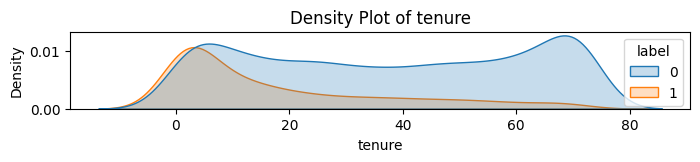

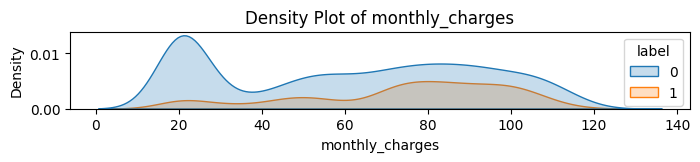

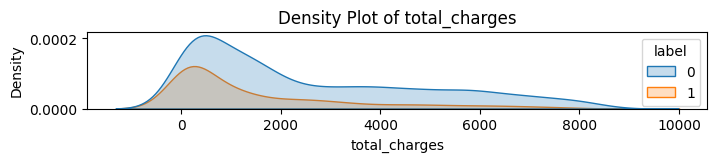

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

features = numerical_data.columns

for feature in features:
    plt.figure(figsize=(8, 1))
    sns.kdeplot(data=data, x=feature, hue='label', fill=True)
    plt.title(f'Density Plot of {feature}')
    plt.xlabel(feature)
    plt.show()

Tenure: Appears to be bimodal with a significant number of customers around 0-5 months and another peak around 70 months. Consider binning to capture short-term vs. long-term customers.  

Monthly Charges: Has a somewhat uniform distribution but with a peak at the lower end. Binning might not be necessary unless you want to group customers into low, medium, and high monthly charge brackets.  

Total Charges: Shows a right-skewed distribution, indicating a concentration of customers with lower total charges and fewer with high total charges. Binning could be useful to group customers into different spending categories.

In [43]:
def bin_features(data):
    '''
    Bins the features 'tenure', 'monthly_charges', and 'total_charges' into predefined categories.
    - 'tenure' is binned into: ['tenure_low', 'tenure_mid_low', 'tenure_mid_high', 'tenure_high']
    - 'monthly_charges' into: ['monthly_low', 'monthly_mid_low', 'monthly_mid_high', 'monthly_high']
    - 'total_charges' into: ['total_low', 'total_high']
    Bins are defined with specific thresholds that help segment these features into meaningful categories.
    This helps in managing the model's sensitivity to variations within these features.
    '''
    bins = {
        'tenure': ([0, 25, 60, float('inf')], 
                   ['tenure_low', 'tenure_mid', 'tenure_high']),
        'monthly_charges': ([0, 30, 70, float('inf')],
                            ['monthly_charges_low', 'monthly_charges_mid', 'monthly_charges_high'])
    }

    # Apply binning
    for feature, (bin_edges, labels) in bins.items():
        data[feature] = pd.cut(data[feature], bins=bin_edges, labels=labels, include_lowest=True)

    return data

data = bin_features(data)
print(data[['tenure', 'monthly_charges']].head())

        tenure       monthly_charges
0   tenure_low   monthly_charges_low
1   tenure_mid  monthly_charges_high
2  tenure_high   monthly_charges_mid
3  tenure_high  monthly_charges_high
4   tenure_mid  monthly_charges_high


One-hot encoding will handle this in the pipeline, but we will continue with EDA on the new binned columns. Drop the original ones as they are no longer needed.

In [44]:
tenure_dummies = pd.get_dummies(data['tenure'])
monthly_charges_dummies = pd.get_dummies(data['monthly_charges'])

data = pd.concat([data, tenure_dummies, monthly_charges_dummies], axis=1)

data.drop(['tenure', 'monthly_charges'], axis=1, inplace=True)

In [45]:
data.dtypes

gender                   object
senior_citizen           object
partner                  object
dependents               object
phone_service            object
multiple_lines           object
internet_service         object
online_security          object
online_backup            object
device_protection        object
tech_support             object
streaming_tv             object
streaming_movies         object
contract                 object
paperless_billing        object
payment_method           object
total_charges           float64
label                     int64
tenure_low                 bool
tenure_mid                 bool
tenure_high                bool
monthly_charges_low        bool
monthly_charges_mid        bool
monthly_charges_high       bool
dtype: object

In [46]:
categorical_data = data.select_dtypes(include=['object', 'bool'])

In [47]:
unique_entries = []

for column in categorical_data.columns:
    # Calculate number of unique entries for each column
    num_unique_entries = categorical_data[column].nunique()
    unique_entries.append((column, num_unique_entries))

unique_entries_df = pd.DataFrame(unique_entries, columns=['column', 'uniques'])
print(unique_entries_df)


                  column  uniques
0                 gender        2
1         senior_citizen        2
2                partner        2
3             dependents        2
4          phone_service        2
5         multiple_lines        3
6       internet_service        3
7        online_security        3
8          online_backup        3
9      device_protection        3
10          tech_support        3
11          streaming_tv        3
12      streaming_movies        3
13              contract        3
14     paperless_billing        2
15        payment_method        4
16            tenure_low        2
17            tenure_mid        2
18           tenure_high        2
19   monthly_charges_low        2
20   monthly_charges_mid        2
21  monthly_charges_high        2


Those are reasonable counts for unique values. This is acceptable for one-hot encoding.

## Preprocessing

We will reference the original raw dataset which we declared at the beginning to be `data_train`. Again, the reason for this is to ensure processing is integrated into the pipeline, as we expected the blind test data to have the same format.

Import the required libraries:

In [48]:
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer, MinMaxScaler, RobustScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from imblearn.over_sampling import RandomOverSampler

Shuffling is good practice because it ensures that the data is randomly distributed which reduces bias when training. This is particularly important when the data might have some sort of order (chronological order or sorted).  
The parameter `frac=1` declares that all rows are to be returned.

In [49]:
data_train = data_train.sample(frac=1, random_state=1)

Drop the 'label' target variable for training. Recall that the ID was previously dropped from the dataset.

In [50]:
X = data_train.drop(columns=['label'])
y = data_train['label']

Perform the split before preprocessing the data to avoid data leakage.

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

Apply oversampling to the training data to handle the class imbalance.

In [52]:
oversampler = RandomOverSampler(random_state=1)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

Define the categorical and numerical features:

In [53]:
binned_features = ['tenure', 'monthly_charges']
# binned_features = ['tenure_low', 'tenure_mid_low', 'tenure_mid_high', 'tenure_high', 'monthly_charges_low', 'monthly_charges_mid_low', 'monthly_charges_mid_high', 'monthly_charges_high', 'total_charges_low', 'total_charges_high']

# Manually adjust feature lists:
numerical_features = [col for col in data_train.columns if (data_train[col].dtype in ['float64', 'int64']) and col not in (['id', 'label', 'senior_citizen'] + binned_features) or col == 'total_charges']
categorical_features = [col for col in data_train.columns if (data_train[col].dtype == 'object' or data_train[col].dtype == bool or col == 'senior_citizen') and col not in ['id', 'label', 'total_charges']]
categorical_features += binned_features

print("numerical features: ", numerical_features)
print("categorical features: ", categorical_features)

numerical features:  ['total_charges']
categorical features:  ['gender', 'senior_citizen', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing', 'payment_method', 'tenure', 'monthly_charges']


Define the preprocessing pipeline.  

A pipeline allows for a structured and repeatable approach to preprocessing data. This ensures that all data, whether it's training data or new data seen in production, undergoes the same transformations. Imputation is particularly important to handle missing values. We declared fill strategies to be 'mean' for numeric features and 'most frequent' for categorical features.

In [54]:
# Custom transformers
transformer_dtype_converter = FunctionTransformer(lambda x: x.astype({'senior_citizen': 'object'})) #senior_citizen
transformer_convert_text = FunctionTransformer(lambda x: x.apply(convert_text), validate=False) # total_charges
transformer_bin_features = FunctionTransformer(lambda x: bin_features(x), validate=False) # tenure and monthly_charges


# Define pipelines for numerical and categorical data processing
numerical_transformer = Pipeline(steps=[
    ('convert_total_charges', transformer_convert_text),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95))
])

categorical_transformer = Pipeline(steps=[
    ('dtype_converter', transformer_dtype_converter),
    ('bin_features', transformer_bin_features), 
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine into a preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

Note that we found better performance with Normalizer() vs. StandardScaler().  

StandardScaler: Scales features to have zero mean and unit variance, adjusting each feature independently.
Normalizer: Scales individual samples to have unit norm, affecting entire rows of data rather than individual features.

## Model Training & Evaluation

Import required libraries:

In [55]:
from datetime import datetime
import pytz 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import roc_auc_score


Define a reusable function to train, evaluate, and store the results.  

Although generally discouraged, a `global` variable was utilized as a convenient way to store the results upon multiple runs without passing the results dataframe.

In [56]:
results = pd.DataFrame(columns=["Datetime", "Model", "ROC_AUC"])

def train_and_test(name, classifier, param_grid=None):
    """
    Trains and tests a machine learning model pipeline, logs results with AUC metric.

    Args:
        name (str): The name of the model for identification.
        classifier (classifier object): The classifier to be used in the pipeline.
        param_grid (dict, optional): Parameters for grid search to optimize the classifier.

    Returns:
        best_model (Pipeline object): The trained model pipeline.

    Updates:
        Appends the performance of the model to the global 'results' DataFrame.
    """
    # Although generally discouraged, a `global` variable was utilized as a convenient way to store the results upon multiple runs without passing the results dataframe.
    global results
    current_datetime = datetime.utcnow() # datetime stamp used for identification
    
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    
    if param_grid:
        grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='roc_auc')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        print("Best Parameters: ", grid_search.best_params_)
    else:
        best_model = model_pipeline
        best_model.fit(X_train, y_train)

    y_probs = best_model.predict_proba(X_test)[:, 1]  # The positive class is at index 1
    roc_auc = round(roc_auc_score(y_test, y_probs),3)
    print("ROC_AUC: ", roc_auc)
    
    result = pd.DataFrame({
        "Datetime": [current_datetime],
        "Model": [name],
        "ROC_AUC": [roc_auc]
    })
    results = pd.concat([results, result])
    
    return best_model

### Logistic Regression

A linear model that predicts the probability of the outcome using the logistic function.

In [57]:
model_fitted_logistic = train_and_test("Logistic Regression", LogisticRegression(max_iter=10000))

ROC_AUC:  0.842


Utilize GridSearchCV and a parameter grid.  

First, replace the warning handler so that we can ignore parameter incompatibilities. The unique warnings will be showed after, so we can be thorough.

In [58]:
# import warnings
# from sklearn.exceptions import FitFailedWarning

# original_showwarning = warnings.showwarning  # Store original handler
# warnings_list = []
# def warn_with_capture(message, category, filename, lineno, file=None, line=None):
#     warnings_list.append(str(message)) 

# warnings.showwarning = warn_with_capture

In [59]:
# param_grid = {
#     'classifier__penalty': ['l1', 'l2', 'elasticnet'],
#     'classifier__C': [0.1, 1, 10, 100],
#     'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#     'classifier__class_weight': [None, 'balanced'],
#     'classifier__l1_ratio': [None, 0.25, 0.5, 0.75]
# }
# model_fitted_logistic_tuned = train_and_test("Logistic Regression tuned", LogisticRegression(max_iter=10000), param_grid)

In [60]:
# unique_warnings = set(warnings_list)
# for warning in unique_warnings:
#     print(warning)
# # Restore original warning behavior
# warnings.showwarning = original_showwarning

No issue. This is what we expected.

### XG Boost  

By PCA inspection, suspect a nonlienar model would be better.

In [61]:
from xgboost import XGBClassifier
model_fitted_xgboost = train_and_test("XG Boost", XGBClassifier(random_state=1))

ROC_AUC:  0.829


Utilize GridSearchCV and a parameter grid.  

First, replace the warning handler so that we can ignore parameter incompatibilities. The unique warnings will be showed after, so we can be thorough.

In [62]:
param_grid = {
    'classifier__n_estimators': [300],
    'classifier__learning_rate': [0.01],
    'classifier__max_depth': [4],
    'classifier__min_child_weight': [3],
    'classifier__subsample': [0.7],
    'classifier__colsample_bytree': [0.7],
    'classifier__gamma': [0.1],
    'classifier__reg_lambda': [2],
    'classifier__reg_alpha': [0.1]
}

model_fitted_xgboost_tuned = train_and_test("XG Boost tuned", XGBClassifier(random_state=1), param_grid)


Best Parameters:  {'classifier__colsample_bytree': 0.7, 'classifier__gamma': 0.1, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 4, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 300, 'classifier__reg_alpha': 0.1, 'classifier__reg_lambda': 2, 'classifier__subsample': 0.7}
ROC_AUC:  0.856


manually tuned params to address overfitting. would need to run cross validation.

### Decision Tree  

A tree-like model where each internal node represents a feature, each branch represents a decision, and each leaf node represents a class label.

In [63]:
model_fitted_decisiontree = train_and_test("Decision Tree", DecisionTreeClassifier())

ROC_AUC:  0.647


### Random Forest  

Ensemble learning method that averages the results of multiple decision trees.

In [64]:
model_fitted_decisiontree = train_and_test("Random Forest", RandomForestClassifier())

ROC_AUC:  0.818


### KNN  

Classifies new examples based on the most common category of its nearest neighbors.

In [65]:
model_knn_fitted = train_and_test("KNN", KNeighborsClassifier())

ROC_AUC:  0.781


## Assess all model performance

In [66]:
results.sort_values(by="ROC_AUC", ascending=False)

,Datetime,Model,ROC_AUC
0,2024-04-29 19:54:30.126068,XG Boost tuned,0.856
0,2024-04-29 19:54:29.106435,Logistic Regression,0.842
0,2024-04-29 19:54:29.762432,XG Boost,0.829
0,2024-04-29 19:54:33.253875,Random Forest,0.818
0,2024-04-29 19:54:34.249442,KNN,0.781
0,2024-04-29 19:54:33.081315,Decision Tree,0.647


## Model Explanation

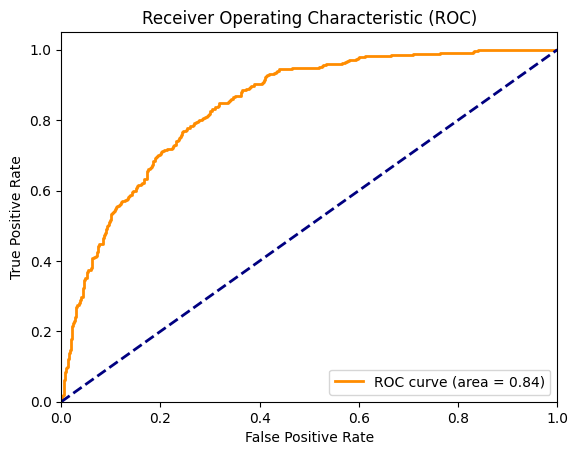

In [67]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_probs = model_fitted_logistic.predict_proba(X_test)[:, 1]  
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

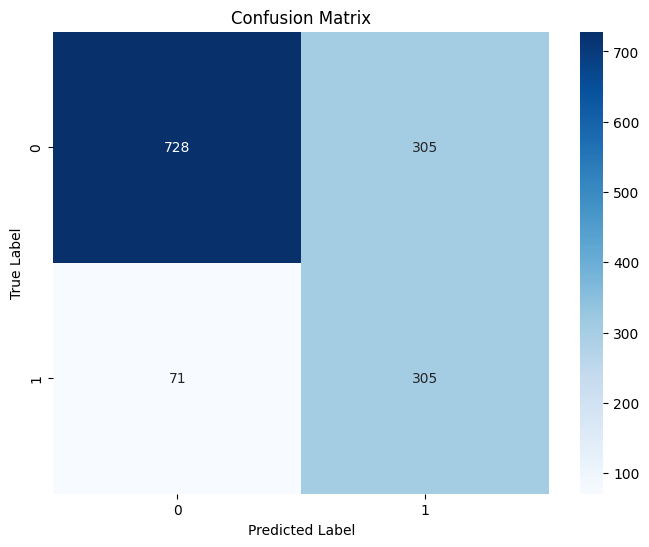

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model_fitted_logistic.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The ROC curve shows a strong model performance with an area under the curve (AUC) of 0.84. This indicates a high true positive rate (TPR) for a given false positive rate (FPR), suggesting that the model has a strong discriminative ability between the positive and negative classes.

The confusion matrix reveals that the model is relatively good at identifying the negative class (non-churn) and is decent in correctly identifying the positive class (churn), as indicated by the relatively small number of false negatives (71). Strategies to improve the identification of the negative class while maintaining the accuracy of the positive class could lead to a significant increase in model performance

In [69]:
from sklearn.compose import ColumnTransformer


def get_categorical_feature_names():

    categorical_transformer = preprocessor.named_transformers_['cat']
    onehot_encoder = categorical_transformer.named_steps['onehot']
    onehot_features = onehot_encoder.get_feature_names_out()
    original_feature_names = preprocessor.transformers_[1][2]  # Ensure the correct index for 'cat'
    categories = onehot_encoder.categories_
    
    # Construct feature names with clearer labels
    feature_names = []
    for orig_feat, cats in zip(original_feature_names, categories):
        feature_names.extend([f"{orig_feat}_{cat}" for cat in cats])
    print("Descriptive onehot_features:", feature_names)
    return feature_names


def get_numerical_feature_names():
    numerical_transformer = preprocessor.named_transformers_['num']
    pca = numerical_transformer.named_steps['pca']
    # Generate names for the PCA components
    num_components = pca.n_components_ if isinstance(pca.n_components, int) else len(pca.explained_variance_ratio_)
    pca_feature_names = [f"PC{i + 1}" for i in range(num_components)]
    print("pca_feature_names", pca_feature_names)
    return pca_feature_names

def get_binned_feature_names():
    # Manual labels for binned features
    binned_features = [
        'tenure_low', 'tenure_mid_low', 'tenure_mid_high', 'tenure_high',
        'monthly_charges_low', 'monthly_charges_mid_low', 'monthly_charges_mid_high', 'monthly_charges_high',
        'total_charges_low', 'total_charges_high'
    ]
    
    return binned_features

def get_all_feature_names():
    num_features = get_numerical_feature_names()  # Features from PCA
    cat_features = get_categorical_feature_names()  # Features from one-hot encoding
    #binned_features = get_binned_feature_names()    # Manually added binned features
    # Combine all feature names
    all_features = num_features + list(cat_features)
    return all_features

all_feature_names = get_all_feature_names()
#print("Features after transformation:", all_feature_names)


pca_feature_names ['PC1']
Descriptive onehot_features: ['gender_Female', 'gender_Male', 'senior_citizen_0', 'senior_citizen_1', 'partner_No', 'partner_Yes', 'dependents_No', 'dependents_Yes', 'phone_service_No', 'phone_service_Yes', 'multiple_lines_No', 'multiple_lines_No phone service', 'multiple_lines_Yes', 'internet_service_DSL', 'internet_service_Fiber optic', 'internet_service_No', 'online_security_No', 'online_security_No internet service', 'online_security_Yes', 'online_backup_No', 'online_backup_No internet service', 'online_backup_Yes', 'device_protection_No', 'device_protection_No internet service', 'device_protection_Yes', 'tech_support_No', 'tech_support_No internet service', 'tech_support_Yes', 'streaming_tv_No', 'streaming_tv_No internet service', 'streaming_tv_Yes', 'streaming_movies_No', 'streaming_movies_No internet service', 'streaming_movies_Yes', 'contract_Month-to-month', 'contract_One year', 'contract_Two year', 'paperless_billing_No', 'paperless_billing_Yes', 'pa

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


classifier = model_fitted_logistic.named_steps['classifier']

coefficients = classifier.coef_[0]
odds_ratios = np.exp(coefficients)

#print(len(all_feature_names), len(coefficients), len(odds_ratios))

feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios
})

sorted_features = feature_importance_df.sort_values(by='Coefficient', ascending=False)


print("Top 10 Positive Features:")
print(sorted_features[['Feature', 'Odds Ratio']].head(10))
print("\nTop 10 Negative Features:")
print(sorted_features[['Feature', 'Odds Ratio']].tail(10))

Top 10 Positive Features:
                            Feature  Odds Ratio
35          contract_Month-to-month    2.333482
15     internet_service_Fiber optic    1.898677
45                tenure_tenure_low    1.667153
17               online_security_No    1.307935
42  payment_method_Electronic check    1.274962
34             streaming_movies_Yes    1.273464
31                 streaming_tv_Yes    1.272978
39            paperless_billing_Yes    1.202229
4                  senior_citizen_1    1.169222
26                  tech_support_No    1.159956

Top 10 Negative Features:
                                   Feature  Odds Ratio
21       online_backup_No internet service    0.868414
3                         senior_citizen_0    0.856054
41  payment_method_Credit card (automatic)    0.855154
38                    paperless_billing_No    0.832551
46                       tenure_tenure_mid    0.803206
47    monthly_charges_monthly_charges_high    0.798834
0                                 

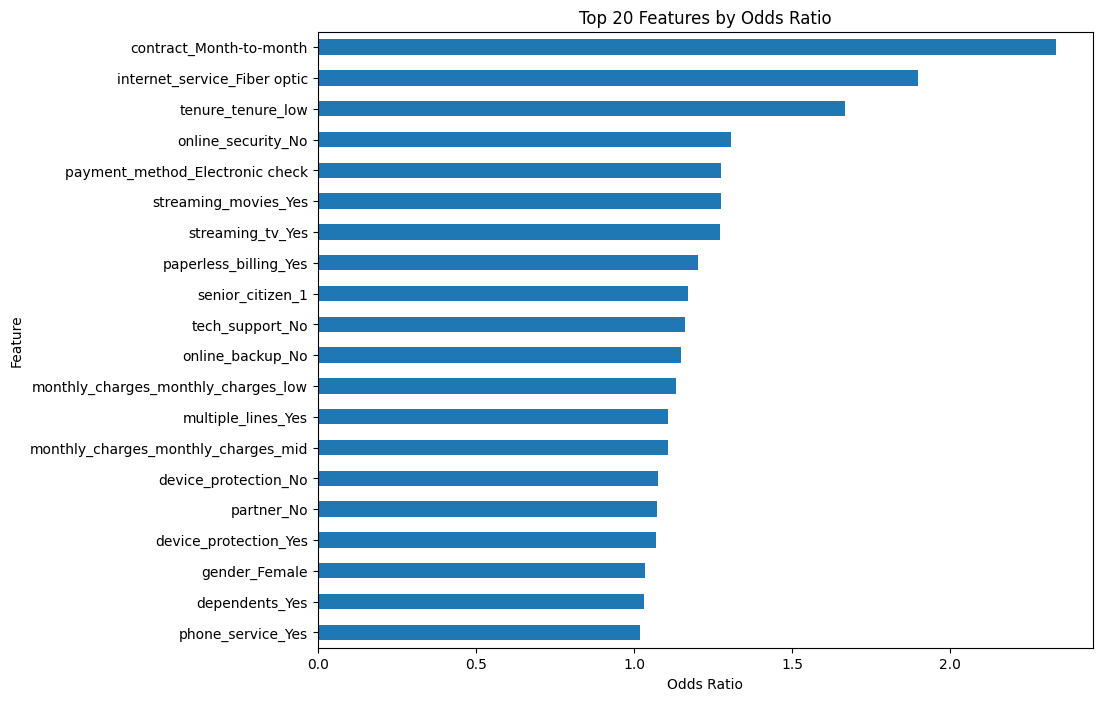

In [71]:
plt.figure(figsize=(10, 8))
sorted_features.set_index('Feature')['Odds Ratio'].nlargest(20).plot(kind='barh')
plt.xlabel('Odds Ratio')
plt.title('Top 20 Features by Odds Ratio')
plt.gca().invert_yaxis() 
plt.show()

The odds ratios offer a highly interpretable way to see which factors significantly influence customer churn. For instance, the feature "internet_service_Fiber optic" has a notably high odds ratio, which means that customers with fiber optic services are near two times higher to churn compared to those without it. This could be attributed to expectations not being met, possibly around service quality or price. 

Similarly, "total_charges" shows a strong positive relationship with churn; higher total charges are associated with increased churn, suggesting that as customers spend more over time, their sensitivity to cost or perceived value may drive them towards discontinuing the service. On the flip side, features like "tenure" and "contract_Two year" have negative coefficients, translating into odds ratios less than 1. This indicates that longer tenure and longer contract terms are significant protective factors against churn, likely due to the increased customer loyalty and the barriers to switching providers that longer contracts often entail.

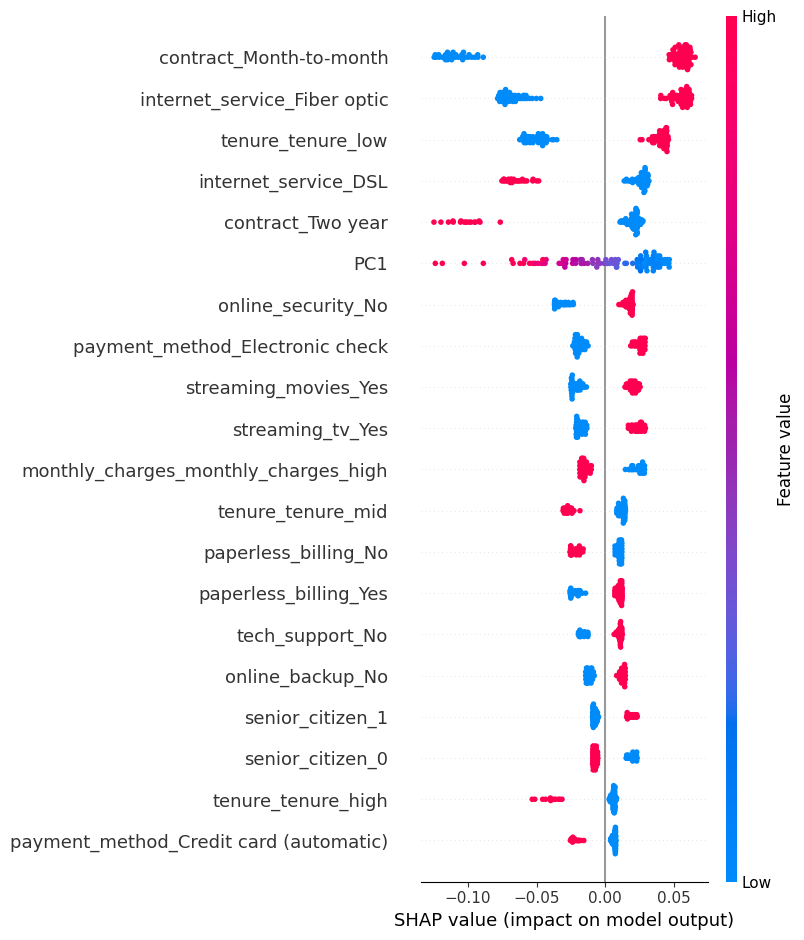

In [72]:
import shap
import numpy as np
import matplotlib.pyplot as plt

X_sample = shap.utils.sample(X_train, 100)
X_sample_processed = preprocessor.transform(X_sample) if preprocessor else X_sample




explainer = shap.Explainer(model_fitted_logistic.named_steps['classifier'].predict_proba, X_sample_processed)
shap_values = explainer(X_sample_processed)
shap_values_positive_class = shap_values[...,1]
shap.summary_plot(shap_values_positive_class, X_sample_processed, feature_names=all_feature_names, show=False)


The SHAP summary plot illustrates the influence of various features on the model's output. The plot ranks features by importance. `contract_Month-to-month` and `internet_service_Fiber optic` are predominant, with higher values positively influencing model predictions—suggestive of a potential correlation with customer loyalty or higher spending over time. Binary categorical features. Conversely, features such as `cat_paperless_billing_Yes` demonstrate a positive impact, which suggests that opting for paperless billing is predictive of a higher model output. 

The color gradient illustrates the value of the feature, where red signifies higher and blue signifies lower values. This shows how their values sway the model's decisions.

## Recommendations

1. Long-term customers demonstrate lower churn rates. Implement loyalty programs to reward tenure and increase customer retention.

2. High total charges correlate with higher churn. Review pricing structures and offer competitive packages or discounts, especially for long-standing customers.

3. Month-to-month contracts are risk factors for churn. Encourage customers to commit to longer-term contracts through incentives.

4. The association of fiber optic services with churn suggests potential issues with service delivery versus customer expectations. Investigate service quality and reliability issues; ensure marketing communication sets realistic expectations.

5. The use of electronic checks is identified as a feature associated with churn. Promote alternative, more convenient automated payment methods that might improve customer satisfaction and reduce churn.

## Run model on blind data 

Load the blind data:

In [73]:
data_blind = pd.read_csv('/kaggle/input/data-idc6210-final-project/test.csv')

Let's evaluate the schema of the blind test set to ensure the pipeline will process the new data as expected.  

Check the dimensions for identical column names. Use the symmetric difference operator (^) to assess the difference.  
Note: If a subtraction sign is used instead, the code would need to be 2 lines: `columns_train - columns_test` and also `columns_test - columns_train`

In [74]:
columns_train = set(X.columns)
columns_test = set(data_blind.columns)
columns_train ^ columns_test

set()

There are no columns missing from either the blind or training sets.  

Check if data types are equivalent:

In [75]:
data_types = data.dtypes
blind_data_types = data_blind.dtypes

mismatched_types = {column: (data_types[column], blind_data_types[column])
                    for column in data.columns.intersection(data_blind.columns)
                    if data_types[column] != blind_data_types[column]}

for column, types in mismatched_types.items():
    print(f"{column} - 'data': {types[0]}, 'data_blind': {types[1]}")

senior_citizen - 'data': object, 'data_blind': int64
total_charges - 'data': float64, 'data_blind': object


In [76]:
test_ids = data_blind['id']
data_blind = data_blind.drop('id', axis=1)

The tuned Logistic Regression model was selected because....

In [77]:
model = model_fitted_logistic
# model = model_fitted_xgboost_tuned

In [78]:
blind_predictions = model.predict(data_blind)

df_predictions = pd.DataFrame({
    'id': test_ids,
    'label': blind_predictions
})
df_predictions.to_csv('GradientDissenters.csv', index=False)